This notebook presents all the analysis reported in Study 1 of the paper.

Click the "Show Code" buttons to see the code associated with each output.

# Preamble

## Libraries

In [1]:
# Misc
import warnings

warnings.filterwarnings("ignore")
from IPython.display import Markdown

# Data libraries
import pandas as pd
import numpy as np

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

sns.set_context("notebook")

# Statistics
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.stats.mstats import zscore
from statsmodels.stats.proportion import proportions_chisquare

# Interface with R
import rpy2

%load_ext rpy2.ipython

STUDY_NAME = "Study 1"

## Functions

In [2]:
# fmt: off
ARRAYS = {
    'Med': np.array([17, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 25, 25, 
                     26, 26, 27, 27, 28, 28, 29, 29, 30, 31, 32, 33, 34]),
    'High': np.array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 
                      26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]),
    'Low': np.array([23, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 
                     26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 28])
}
# fmt: on


def plot_design(
    save=False, grayscale=False, show=True, figname=f"Appendix - {STUDY_NAME} - Design"
):
    low_s1 = ARRAYS["Low"]
    med_s1 = ARRAYS["Med"]
    high_s1 = ARRAYS["High"]
    if grayscale:
        pal = sns.color_palette("Greys")[2::3]
        pathname = "Grayscale"
    else:
        pal = sns.color_palette()[0:2]
        pathname = "Color"

    if save:
        sns.set_context("paper")
    else:
        sns.set_context("notebook")

    sns.set_style("ticks")
    fig, axes = plt.subplots(3, 1, figsize=(5, 6.38))
    axes = axes.flatten()
    for i, (manip, common, title) in enumerate(
        zip(
            [low_s1, med_s1, high_s1],
            [med_s1, med_s1, med_s1],
            ["SD = 1.1", "SD = 4.5", "SD = 7.5"],
        )
    ):
        ax = axes[i]
        ax.annotate(title, (21, 5), size=12, va="center", ha="center")
        bins = np.arange(0, 51, 1)
        ax.hist(
            common,
            bins=bins,
            label="Common",
            color=pal[1],
            density=False,
            align="left",
            rwidth=0.7,
            lw=0,
        )
        ax.hist(
            manip,
            bins=bins,
            label="Manipulated",
            color=pal[0],
            density=False,
            align="left",
            rwidth=0.35,
            lw=0,
        )
        leg = ax.legend()
        han = leg.legendHandles
        leg.remove()
        ax.set_xticks(np.arange(12, 40, 2))
        ax.set_xticklabels([f"${i}" for i in np.arange(12, 40, 2)])
        ax.set_xlim(10, 40)
        ax.set_ylim(0, 10)
        ax.set_yticklabels(np.arange(0, 12, 2))
        ax.set_ylabel("Number of Items")

    axes[0].legend(
        handles=han,
        loc="center left",
        title="Category",
        frameon=False,
        bbox_to_anchor=(0.6, 0.75),
    )

    sns.despine()
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.15, left=0)

    if save:
        plt.savefig(
            f"../Figures/{pathname}/{figname}.png", dpi=100, bbox_inches="tight"
        )
    if show:
        plt.show()
    else:
        plt.close()


def plot_result_stats(
    data,
    save=False,
    grayscale=False,
    show=True,
    figname=f"Fig 1 - {STUDY_NAME} - Results Min and Max",
):
    if grayscale:
        pal = sns.color_palette("Greys")[1::2]
        pathname = "Grayscale"
    else:
        pal = sns.color_palette("coolwarm", 3)
        pathname = "Color"

    if show:
        sns.set_context("notebook")
    else:
        sns.set_context("paper")

    g = sns.catplot(
        x="is_manipulated",
        y="value",
        data=data,
        row="variable",
        kind="bar",
        hue="sd_manipulated_label",
        legend=False,
        aspect=1.8,
        order=[True, False],
        palette=pal,
        height=6.38 / 1.8,
        sharey=False,
    )
    g.axes[0][0].legend(
        title="SD of Manipulated Category", loc="upper center", frameon=False, bbox_to_anchor=(.5, 1.1)
    )
    g.set_xticklabels(["Manipulated Category", "Common Category (SD = 4.5)"])
    g.set_xlabels("")
    g.set_titles("")
    g.axes[0][0].set_ylabel("Reported Minimum")
    g.axes[0][0].set_ylim(12.5, 22)
    g.axes[1][0].set_ylim(25, 38)
    g.axes[1][0].set_ylabel("Reported Maximum")
    for ax in g.axes.flatten():
        ax.tick_params(
            axis="x", which="both", bottom=False, top=False, labelbottom=True
        )
    plt.tight_layout()
    if save:
        plt.savefig(
            f"../Figures/{pathname}/{figname}.png", dpi=100, bbox_inches="tight"
        )
    if show:
        plt.show()
    else:
        plt.close()


def plot_cdf_stats(
    data,
    save=False,
    show=True,
    grayscale=False,
    figname=f"Fig 2a - {STUDY_NAME} - CDF Min",
    stats="min",
):
    if grayscale:
        pal = sns.color_palette("Greys")[1::2]
        pathname = "Grayscale"
    else:
        pal = sns.color_palette("coolwarm", 3)
        pathname = "Color"

    if show:
        sns.set_context("notebook")
    else:
        sns.set_context("paper")
    sns.set_style("ticks")

    if stats == "min":
        statsname = "Min"
        bins = np.arange(4, 100, 1)
        ticks = np.arange(5, 31, 2)
        coords = [23, 17, 13]
        lims = (3, 32)
    else:
        statsname = "Max"
        bins = np.arange(20, 100, 1)
        ticks = np.arange(22, 51, 2)
        coords = [28, 34, 38]
        lims = (20, 52)

    df_common = df_clean.loc[df_clean.is_manipulated == 0]
    g = sns.FacetGrid(
        hue="sd_manipulated_label",
        data=data,
        aspect=2,
        height=4,
        palette=pal,
        gridspec_kws={"hspace": 0.4},
    )
    g.map(
        plt.hist,
        f"memory_{stats}",
        bins=bins,
        density=True,
        alpha=1,
        histtype="step",
        cumulative=True,
        align="mid",
        lw=2,
    )

    g.set_xlabels(f"{statsname}imum Price Reported for Common Category")
    g.set_ylabels("Cumulative Prop. of Participants")

    for xpos, color in zip(coords, pal):
        g.ax.axvline(xpos, color=color, ls="--")
    g.ax.axvline(coords[1], ls="-", color="grey", lw=0.6)

    legend_elements = [
        Line2D(
            [0],
            [0],
            color="grey",
            ls="--",
            lw=2,
            label=f"True {statsname} of Manipulated",
        ),
        Line2D([0], [0], color=pal[0], lw=4, label="Low (SD = 1.1)"),
        Line2D(
            [0], [0], color="grey", ls="-", lw=1, label=f"True {statsname} of Common"
        ),
        Line2D([0], [0], color=pal[1], lw=4, label="Med (SD = 4.5)"),
        Line2D([0], [0], color="white", lw=2, label=""),
        Line2D([0], [0], color=pal[2], lw=4, label="High (SD = 7.5)"),
    ]

    g.ax.legend(
        handles=legend_elements,
        loc="center",
        ncol=3,
        frameon=True,
        bbox_to_anchor=(0.5, -0.3),
    )

    g.ax.set_ylim(0, 1.1)
    g.ax.set_xlim(lims)
    g.ax.set_xticks(ticks)
    g.ax.set_xticklabels([f"${i}" for i in ticks])
    plt.tight_layout()
    if save:
        plt.savefig(
            f"../Figures/{pathname}/{figname}.png", dpi=100, bbox_inches="tight"
        )
    if show:
        plt.show()
    else:
        plt.close()


def format_pvals(p):
    if p < 0.001:
        return "p < .001"
    else:
        return f"p = {p:.3f}"

## Data loading and preparation

In [3]:
df = pd.read_csv(f"../Data/{STUDY_NAME}/LongData.csv")
df["actual_min"] = df.apply(
    lambda x: ARRAYS[x.sd_manipulated].min()
    if x.is_manipulated
    else ARRAYS["Med"].min(),
    axis=1,
)
df["actual_max"] = df.apply(
    lambda x: ARRAYS[x.sd_manipulated].max()
    if x.is_manipulated
    else ARRAYS["Med"].max(),
    axis=1,
)


df["below_actual_min"] = (df.memory_min < df.actual_min) * 1
df["above_actual_max"] = (df.memory_max > df.actual_max) * 1

df["actual_range"] = df["actual_max"] - df["actual_min"]
df["wider_actual_range"] = (df.memory_range > df.actual_range) * 1

df["above_actual_min"] = (df.memory_min > df.actual_min) * 1
df["below_actual_max"] = (df.memory_max < df.actual_max) * 1

df["is_manipulated_label"] = df.is_manipulated.map({0: "Common", 1: "Manipulated"})

df_clean = df[df.valid_response]

# Design

## Independent variable

Each participant sees two distributions, one "manipulated", one "common".
* The "common" distribution always has a "Medium" amount of variance (SD = 4.5, Min = 17, Max = 34)
* The "manipulated" distribution has a different variance, between subjects:
    * "Low" (SD = 1.1, Min = 23, Max = 28)
    * "Medium" (SD = 4.5, Min = 17, Max = 34)
    * "High" (SD = 7.5, Min = 13, Max = 38)
    
In addition, we counterbalance the label of the "manipulated" category: red wines or white wines.

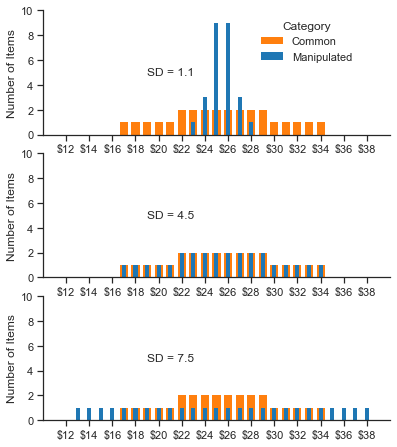

In [4]:
plot_design(save=False, show=True)

## Dependent variable and hypothesis


For each category (red wine and white wines), we instead elicit from participants:
* The minimum price that they remember seeing.
* The maximum price that they remember seeing.

## Participants and exclusions

In [5]:
Markdown(
    f"""
We collected {df.shape[0]//2} participants, and excluded {(df.shape[0] - df_clean.shape[0])//2} 
participants who reported a higher price that was strictly smaller than the lower price. 
Results are unaffected by this deletion.
"""
)


We collected 300 participants, and excluded 7 
participants who reported a higher price that was strictly smaller than the lower price. 
Results are unaffected by this deletion.


# Analysis

## Overview of results

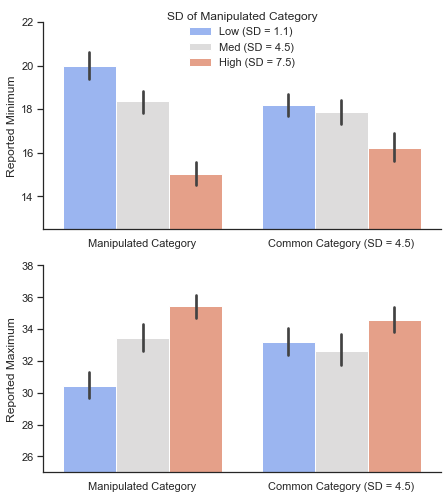

In [6]:
df_both = pd.melt(
    df_clean,
    id_vars=["is_manipulated", "sd_manipulated", "sd_manipulated_label", "turkid"],
    value_vars=["memory_min", "memory_max"],
)
df_both["variable"] = df_both.variable.map(
    {"memory_min": "Minimum", "memory_max": "Maximum"}
)
plot_result_stats(df_both, save=True, show=True)
plot_result_stats(df_both, grayscale=True, save=True, show=False)

table = (
    df_clean.groupby(["is_manipulated", "sd_manipulated"])[["memory_min", "memory_max"]]
    .mean()
    .reindex(
        labels=[
            [False, False, False, True, True, True],
            ["Low", "Med", "High", "Low", "Med", "High"],
        ]
    )
)
table.index.names = ["Manipulated?", "SD of Manipulated"]
table.columns = ["Minimum", "Maximum"]
table.style.format("{:.2f}")

## Minimum

In [7]:
model = smf.mixedlm(
    "memory_min ~ C(sd_manipulated, levels=['Med', 'Low', 'High'])\
*C(is_manipulated)",
    data=df_clean,
    groups=df_clean.turkid,
).fit()
model.summary(
    yname="Reported Maximum",
    xname_fe=[
        "Intercept",
        "Dispersion: Low (vs. Medium)",
        "Dispersion: High (vs. Medium)",
        "Target: Manipulated (vs. Common)",
        "Dispersion: Low * Target",
        "Dispersion: High * Target",
    ],
)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                 MixedLM     Dependent Variable:     Reported Maximum
No. Observations:      586         Method:                 REML            
No. Groups:            293         Scale:                  5.3301          
Min. group size:       2           Log-Likelihood:         -1431.4938      
Max. group size:       2           Converged:              Yes             
Mean group size:       2.0                                                 
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        17.880    0.289 61.929 0.000 17.314 18.446
Dispersion: Low (vs. Medium)      0.314    0.410  0.765 0.444 -0.490  1.118
Dispersion: High (vs. Medium)    -1.648    0.414 -3.985 0.000 -2.459 -0.838
Target: Manipulated (vs. Common)  0.480    0.327  1.470 0.142 -0.160  1.120
Dispersion: Low * Target          1.326    0.464  2.857 0.004  0.417  2.236
Dispersion: High * Target        -1.680    0.468 -3.591 0.000 -2.597 -0.763
Group Var                         3.006    0.288                           
===========================================================================

"""

Standardized betas:

In [8]:
stdbetas = model.params[:-1] / df_clean.memory_min.std(ddof=1)
stdbetas.index = [
    "Intercept",
    "Dispersion: Low (vs. Medium)",
    "Dispersion: High (vs. Medium)",
    "Target: Manipulated (vs. Common)",
    "Dispersion: Low * Target",
    "Dispersion: High * Target",
]
table = pd.DataFrame(stdbetas, columns=["Standardized Betas"])
table.style.format("{:.2f}")

,Standardized Betas
Intercept,5.45
Dispersion: Low (vs. Medium),0.10
Dispersion: High (vs. Medium),-0.50
Target: Manipulated (vs. Common),0.15
Dispersion: Low * Target,0.40
Dispersion: High * Target,-0.51


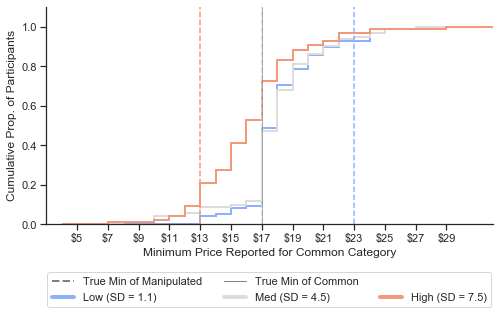

In [9]:
df_common = df_clean[df_clean.is_manipulated == 0]
plot_cdf_stats(
    df_common, stats="min", figname="Fig 2a - Study 1a - CDF Min", save=True, show=True
)
plot_cdf_stats(
    df_common,
    stats="min",
    figname="Fig 2a - Study 1a - CDF Min",
    grayscale=True,
    save=True,
    show=False,
)

In [10]:
nobs = df_common.groupby("sd_manipulated").below_actual_min.count()
nsuc = df_common.groupby("sd_manipulated").below_actual_min.sum()
props = nsuc / nobs * 100

chi_hvm, p_hvm = proportions_chisquare(nsuc[[0, 2]], nobs[[0, 2]])[0:2]
chi_hvl, p_hvl = proportions_chisquare(nsuc[[0, 1]], nobs[[0, 1]])[0:2]
chi_mvl, p_mvl = proportions_chisquare(nsuc[[1, 2]], nobs[[1, 2]])[0:2]

Markdown(
    f"""
When the price dispersion in the manipulated category was higher, {props[0]:.0f}% of participants 
reported a minimum price for the common category that was lower than the actual minimum price that they learned. 
In contrast, only {props[2]:.0f}% ({props[1]:.0f}%) of participants did so when the manipulated had as much (less)
price dispersion ({props[0]:.0f}% vs. {props[2]:.0f}%: $\chi$(1) = {chi_hvl:.2f}, {format_pvals(p_hvl)}; 
{props[0]:.0f}% vs. {props[1]:.0f}%: $\chi$(1) = {chi_hvm:.2f}, {format_pvals(p_hvm)}; {props[2]:.0f}% vs. 
{props[1]:.0f}%:  $\chi$(1) = {chi_mvl:.2f}, {format_pvals(p_mvl)}). 
"""
)


When the price dispersion in the manipulated category was higher, 53% of participants 
reported a minimum price for the common category that was lower than the actual minimum price that they learned. 
In contrast, only 12% (9%) of participants did so when the manipulated had as much (less)
price dispersion (53% vs. 12%: $\chi$(1) = 42.90, p < .001; 
53% vs. 9%: $\chi$(1) = 37.09, p < .001; 12% vs. 
9%:  $\chi$(1) = 0.41, p = 0.520). 


## Maximum

In [11]:
model = smf.mixedlm(
    "memory_max ~ C(sd_manipulated, levels=['Med', 'Low', 'High'])\
*C(is_manipulated)",
    data=df_clean,
    groups=df_clean.turkid,
).fit()
model.summary(
    yname="Reported Maximum",
    xname_fe=[
        "Intercept",
        "Dispersion: Low (vs. Medium)",
        "Dispersion: High (vs. Medium)",
        "Target: Manipulated (vs. Common)",
        "Dispersion: Low * Target",
        "Dispersion: High * Target",
    ],
)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                 MixedLM     Dependent Variable:     Reported Maximum
No. Observations:      586         Method:                 REML            
No. Groups:            293         Scale:                  7.9755          
Min. group size:       2           Log-Likelihood:         -1616.6643      
Max. group size:       2           Converged:              Yes             
Mean group size:       2.0                                                 
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        32.650    0.419 77.875 0.000 31.828 33.472
Dispersion: Low (vs. Medium)      0.534    0.596  0.896 0.371 -0.634  1.702
Dispersion: High (vs. Medium)     1.918    0.601  3.194 0.001  0.741  3.096
Target: Manipulated (vs. Common)  0.810    0.399  2.028 0.043  0.027  1.593
Dispersion: Low * Target         -3.555    0.568 -6.262 0.000 -4.668 -2.442
Dispersion: High * Target         0.074    0.572  0.130 0.897 -1.047  1.196
Group Var                         9.602    0.565                           
===========================================================================

"""

Standardized betas:

In [12]:
stdbetas = model.params[:-1] / df_clean.memory_max.std(ddof=1)
stdbetas.index = [
    "Intercept",
    "Dispersion: Low (vs. Medium)",
    "Dispersion: High (vs. Medium)",
    "Target: Manipulated (vs. Common)",
    "Dispersion: Low * Target",
    "Dispersion: High * Target",
]
table = pd.DataFrame(stdbetas, columns=["Standardized Betas"])
table.style.format("{:.2f}")

,Standardized Betas
Intercept,7.32
Dispersion: Low (vs. Medium),0.12
Dispersion: High (vs. Medium),0.43
Target: Manipulated (vs. Common),0.18
Dispersion: Low * Target,-0.80
Dispersion: High * Target,0.02


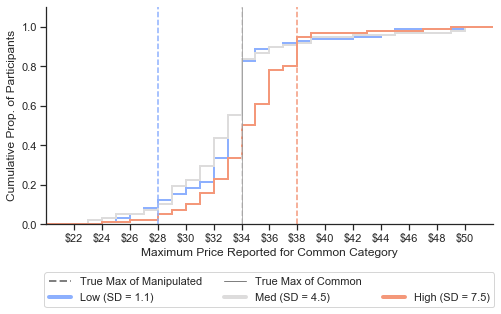

In [13]:
df_common = df_clean[df_clean.is_manipulated == 0]
plot_cdf_stats(
    df_common, stats="max", figname="Fig 2b - Study 1a - CDF Max", save=True, show=True
)
plot_cdf_stats(
    df_common,
    stats="max",
    figname="Fig 2b - Study 1a - CDF Max",
    grayscale=True,
    save=True,
    show=False,
)

In [14]:
nobs = df_common.groupby("sd_manipulated").above_actual_max.count()
nsuc = df_common.groupby("sd_manipulated").above_actual_max.sum()
props = nsuc / nobs * 100

chi_hvm, p_hvm = proportions_chisquare(nsuc[[0, 2]], nobs[[0, 2]])[0:2]
chi_hvl, p_hvl = proportions_chisquare(nsuc[[0, 1]], nobs[[0, 1]])[0:2]
chi_mvl, p_mvl = proportions_chisquare(nsuc[[1, 2]], nobs[[1, 2]])[0:2]

Markdown(
    f"""
When the price dispersion in the manipulated category was higher than the price dispersion in the common category, 
{props[0]:.0f}% of participants reported seeing a maximum price higher than the actual maximum price. 
In contrast, only {props[2]:.0f}% ({props[1]:.0f}%) of participants did this when the price dispersion of the manipulated 
category was equal (lower) ({props[0]:.0f}% vs. {props[2]:.0f}%: $\chi$(1) = {chi_hvl:.2f}, {format_pvals(p_hvl)}; 
{props[0]:.0f}% vs. {props[1]:.0f}%: $\chi$(1) = {chi_hvm:.2f}, {format_pvals(p_hvm)};  {props[1]:.0f}% vs.
{props[2]:.0f}%:  $\chi$(1) = {chi_mvl:.2f}, {format_pvals(p_mvl)}). 
"""
)


When the price dispersion in the manipulated category was higher than the price dispersion in the common category, 
49% of participants reported seeing a maximum price higher than the actual maximum price. 
In contrast, only 16% (17%) of participants did this when the price dispersion of the manipulated 
category was equal (lower) (49% vs. 16%: $\chi$(1) = 22.46, p < .001; 
49% vs. 17%: $\chi$(1) = 24.96, p < .001;  17% vs.
16%:  $\chi$(1) = 0.06, p = 0.799). 


The dispersion of the "manipulated" distribution has an asymmetric effect on the perception of the "common" distribution:
* When the dispersion is "high", it inflates the perceived range.
* When the dispersion is "low", it has no detectable bearing on the perceived range.

# Robustness Checks

## Counterbalancing factor - Maximum

In [15]:
model = smf.mixedlm(
    "memory_max ~ C(sd_manipulated, levels=['Med', 'Low', 'High'])\
*C(is_manipulated)*C(name_manipulated, Sum)",
    data=df_clean,
    groups=df_clean.turkid,
).fit()
model.summary(
    yname="Reported Maximum",
    xname_fe=[
        "Intercept",
        "Dispersion: Low (vs. Medium)",
        "Dispersion: High (vs. Medium)",
        "Target: Manipulated (vs. Common)",
        "Counterbalancing Factor (CF)",
        "Dispersion: Low * Target",
        "Dispersion: High * Target",
        "Dispersion: Low * CF",
        "Dispersion: High * CF",
        "Target * CF",
        "Dispersion: Low * Target * CF",
        "Dispersion: High * Target * CF",
    ],
)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                 MixedLM     Dependent Variable:     Reported Maximum
No. Observations:      586         Method:                 REML            
No. Groups:            293         Scale:                  8.0053          
Min. group size:       2           Log-Likelihood:         -1614.5463      
Max. group size:       2           Converged:              Yes             
Mean group size:       2.0                                                 
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        32.635    0.420 77.706 0.000 31.812 33.459
Dispersion: Low (vs. Medium)      0.568    0.597  0.951 0.342 -0.602  1.738
Dispersion: High (vs. Medium)     1.926    0.601  3.202 0.001  0.747  3.105
Target: Manipulated (vs. Common)  0.817    0.400  2.039 0.041  0.032  1.601
Counterbalancing Factor (CF)     -0.365    0.420 -0.868 0.385 -1.188  0.459
Dispersion: Low * Target         -3.572    0.569 -6.276 0.000 -4.688 -2.457
Dispersion: High * Target         0.073    0.574  0.127 0.899 -1.051  1.197
Dispersion: Low * CF             -0.113    0.597 -0.189 0.850 -1.283  1.057
Dispersion: High * CF            -0.282    0.601 -0.469 0.639 -1.461  0.897
Target * CF                       0.163    0.400  0.406 0.685 -0.622  0.948
Dispersion: Low * Target * CF     0.103    0.569  0.181 0.857 -1.013  1.219
Dispersion: High * Target * CF    0.310    0.574  0.540 0.589 -0.814  1.434
Group Var                         9.605    0.568                           
===========================================================================

"""

## Counterbalancing factor - Minimum

In [16]:
model = smf.mixedlm(
    "memory_min ~ C(sd_manipulated, levels=['Med', 'Low', 'High'])\
*C(is_manipulated)*C(name_manipulated, Sum)",
    data=df_clean,
    groups=df_clean.turkid,
).fit()
model.summary(
    yname="Reported Minimum",
    xname_fe=[
        "Intercept",
        "Dispersion: Low (vs. Medium)",
        "Dispersion: High (vs. Medium)",
        "Target: Manipulated (vs. Common)",
        "Counterbalancing Factor (CF)",
        "Dispersion: Low * Target",
        "Dispersion: High * Target",
        "Dispersion: Low * CF",
        "Dispersion: High * CF",
        "Target * CF",
        "Dispersion: Low * Target * CF",
        "Dispersion: High * Target * CF",
    ],
)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                 MixedLM     Dependent Variable:     Reported Minimum
No. Observations:      586         Method:                 REML            
No. Groups:            293         Scale:                  5.2506          
Min. group size:       2           Log-Likelihood:         -1428.6084      
Max. group size:       2           Converged:              Yes             
Mean group size:       2.0                                                 
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        17.864    0.288 61.942 0.000 17.299 18.429
Dispersion: Low (vs. Medium)      0.341    0.410  0.831 0.406 -0.463  1.144
Dispersion: High (vs. Medium)    -1.638    0.413 -3.966 0.000 -2.448 -0.829
Target: Manipulated (vs. Common)  0.509    0.324  1.569 0.117 -0.127  1.144
Counterbalancing Factor (CF)     -0.405    0.288 -1.406 0.160 -0.971  0.160
Dispersion: Low * Target          1.282    0.461  2.782 0.005  0.379  2.186
Dispersion: High * Target        -1.705    0.464 -3.671 0.000 -2.615 -0.795
Dispersion: Low * CF              0.142    0.410  0.346 0.729 -0.661  0.945
Dispersion: High * CF            -0.161    0.413 -0.389 0.697 -0.970  0.649
Target * CF                       0.720    0.324  2.221 0.026  0.085  1.356
Dispersion: Low * Target * CF    -0.355    0.461 -0.769 0.442 -1.258  0.549
Dispersion: High * Target * CF   -0.354    0.464 -0.762 0.446 -1.264  0.556
Group Var                         3.053    0.293                           
===========================================================================

"""